#  Importing Libraries

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
#!pip install plot-utils
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow Version:',tf.__version__)

Tensorflow Version: 2.2.0


#  Load and Preprocess the data

In [2]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

4423680/4422102 [==============================] - 0s 0us/step


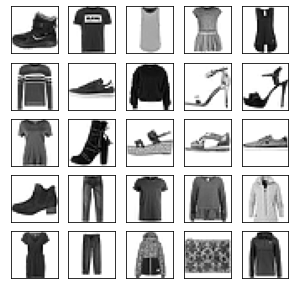

In [3]:
plt.figure(figsize = (5,5))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

# Creating batches of training data

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size,drop_remainder = True).prefetch(1)

# Building the generator Network 

In [0]:
num_features = 100

generator = keras.models.Sequential([
     keras.layers.Dense(7 * 7 * 128, input_shape = [num_features]),
     keras.layers.Reshape([7,7,128]),
     keras.layers.BatchNormalization(),
     keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation= 'selu'),
     keras.layers.BatchNormalization(),
     keras.layers.Conv2DTranspose(1,(5,5) , (2,2), padding='same', activation='tanh')

])

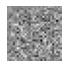

In [6]:
noise = tf.random.normal(shape=[1,num_features])
generated_image = generator(noise, training= False)
plot_utils.show(generated_image,1)

# Build the Discriminator Network for DCGAN

In [0]:
discriminator = keras.models.Sequential([
        keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape = [28,28,1]),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Dropout(0.3),
        keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation='sigmoid')

])

In [8]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5034884]], shape=(1, 1), dtype=float32)


# Compile the Deep Convolutional Generative Adversarial Network

In [0]:
discriminator.compile(optimizer='rmsprop', loss='binary_crossentropy')
discriminator.trainable= False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(optimizer='rmsprop',loss='binary_crossentropy')

# Define Training Procedure

In [0]:
seed = tf.random.normal(shape=[batch_size,100]) 

In [0]:
def train_dcgan(gan,dataset,batch_size,num_features,epochs=5):
  generator, discriminator = gan.layers
  for epoch in tqdm(range(epochs)):
    print("Epochs {}/{}".format(epoch + 1, epochs))
    for X_batch in dataset:
      noise = tf.random.normal(shape=[batch_size,num_features])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images,X_batch],axis=0)
      y1 = tf.constant([[0.]]* batch_size + [[1.]]* batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real,y1)
      y2 = tf.constant([[1.]]* batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1 , seed)
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs , seed)
  
    


In [0]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train DCGAN

In [0]:
x_train_dcgan = x_train.reshape(-1,28,28,1)* 2. -1.

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

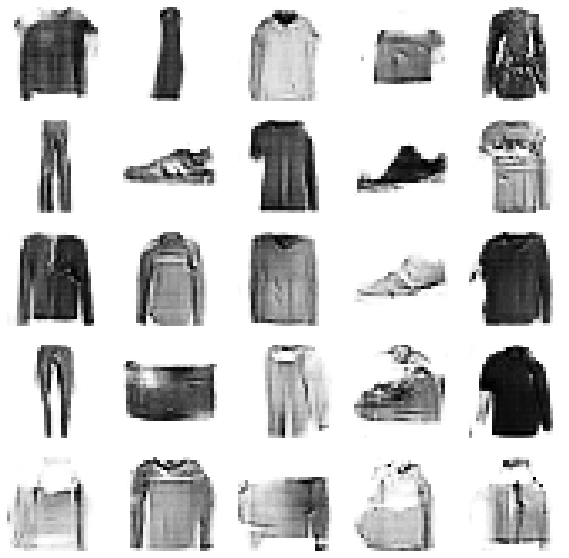

CPU times: user 8min 4s, sys: 36 s, total: 8min 40s
Wall time: 11min 55s


In [15]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)

# Generate Synthetic Images with DCGAN

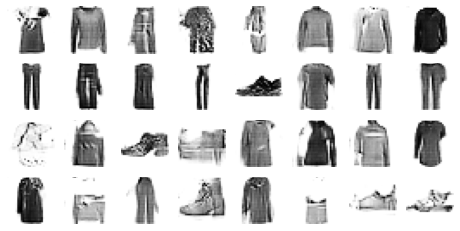

In [21]:
noise = tf.random.normal(shape=[batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images,8)

In [0]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

#import IPython
#display.Image(filename=anim_file)

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

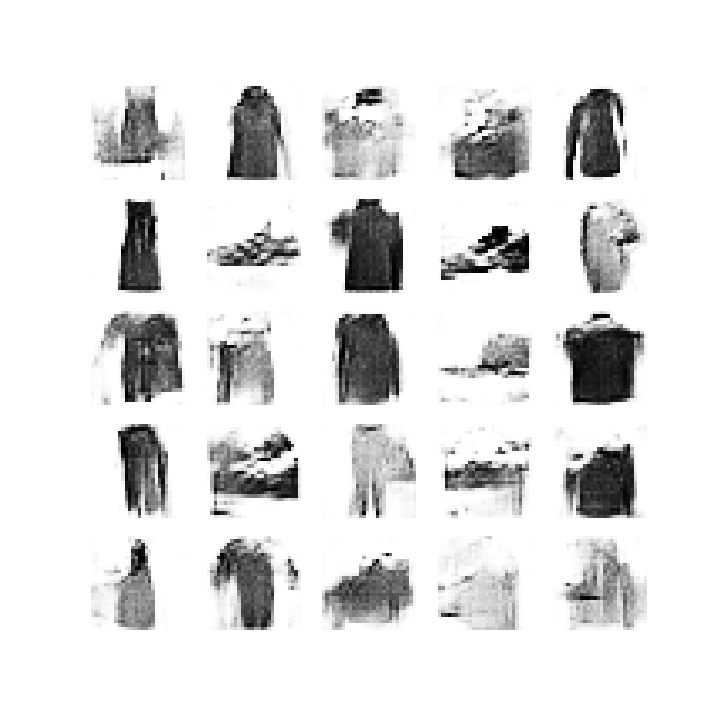

In [26]:
gifPath =("/content/dcgan.gif") 
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')